Why do polynomial regressions fail in high dimensions?

In [3]:
using LinearAlgebra, Plots

Let's say we have a fairly noisy dataset this exhibits a clear non-linear relationship, but we're not certain about what type. One of the approaches we might consider is using a polynomial regression as with the right degree we will have a very interpretable result as opposed to a quick and dirty rbf support vector regression.

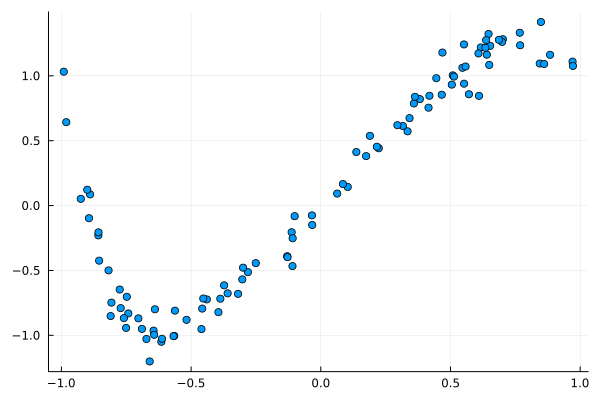

In [4]:
xv = (rand(100) .- 0.5) .* 2
Y = @. xv ^ 6 - 2 * xv^5 + 2*xv
Y .+= randn(100) .* 0.1
scatter(xv, Y, legend = false)

Let's start by doing a quadratic regression, we construct a matrix $X$ from $xv$ by mapping each $x_i$ in $xv$ to the vector $[x_i^2 \: x_i \: 1]$ 

In [5]:
X = (xv .|> x -> [x^2 x 1])
X = vcat(X...)
X[1:5, :]

5×3 Matrix{Float64}:
 0.319317  -0.565082  1.0
 0.790744  -0.889238  1.0
 0.305116   0.552373  1.0
 0.13882   -0.372585  1.0
 0.145889   0.381954  1.0

We're using OLS, so our solution is $w = (X^TX)^{-1}Y^TX$

SSE = 13.574818499704577

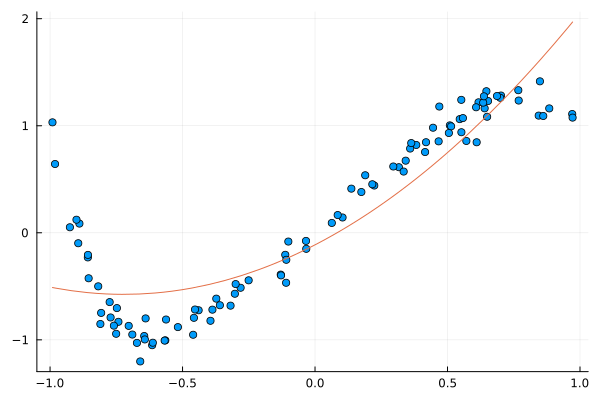

In [6]:
w = (X'X)^-1 * X'Y
print("SSE = ", (X*w -Y)'*(X*w -Y))
plot!(x -> w[1] * x^2 + w[2] * x + w[3])

Doesn't look like a good fit, we need more degrees

In [7]:
X = (xv .|> x -> [x^3 x^2 x 1])
X = vcat(X...)
X[1:5, :]

5×4 Matrix{Float64}:
 -0.18044    0.319317  -0.565082  1.0
 -0.70316    0.790744  -0.889238  1.0
  0.168538   0.305116   0.552373  1.0
 -0.0517221  0.13882   -0.372585  1.0
  0.0557229  0.145889   0.381954  1.0

SSE = 2.83007783665526

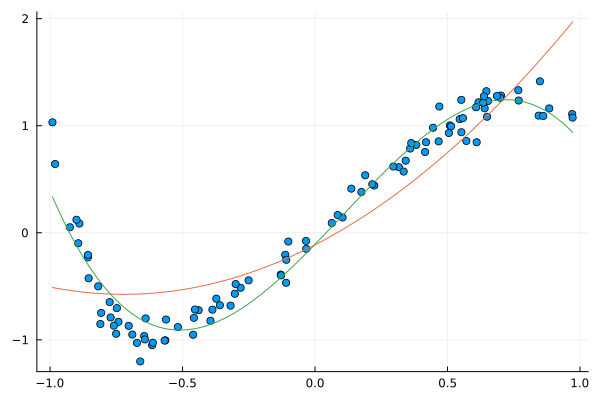

In [8]:
w = (X'X)^-1 * X'Y
print("SSE = ", (X*w -Y)'*(X*w -Y))
plot!(x -> w[1] * x^3 + w[2] * x^2 + w[3] * x + w[4])

We're getting better, but still we could benefit from a couple more degrees

In [9]:
degrees = 5
X = (xv .|> x -> [x^n for n in degrees:-1:0])
X = hcat(X...)'
X[1:5, :]

5×6 Matrix{Float64}:
 -0.0576177   0.101963   -0.18044    0.319317  -0.565082  1.0
 -0.55602     0.625276   -0.70316    0.790744  -0.889238  1.0
  0.0514236   0.0930958   0.168538   0.305116   0.552373  1.0
 -0.00718003  0.0192709  -0.0517221  0.13882   -0.372585  1.0
  0.00812936  0.0212836   0.0557229  0.145889   0.381954  1.0

SSE = 1.1733803314073097

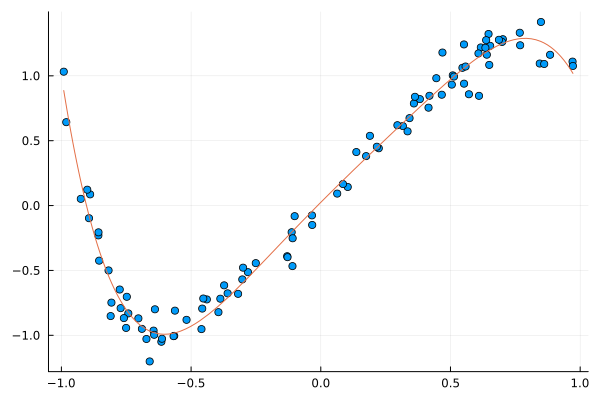

In [10]:
w = (X'X)^-1 * X'Y
scatter(xv, Y, legend = false)
print("SSE = ", (X*w -Y)'*(X*w -Y))
plot!(x -> dot([x^n for n in degrees:-1:0],w))

Almost there

SSE = 1.1097031923209515

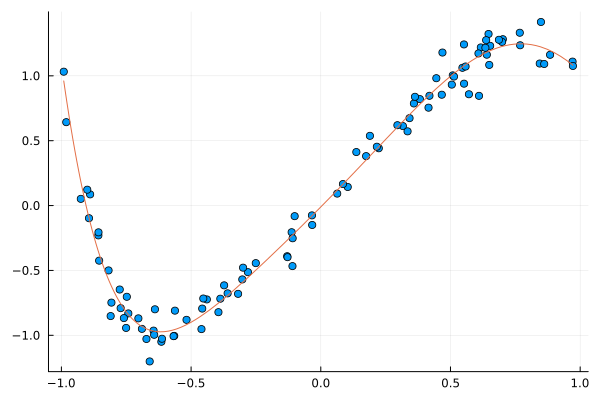

In [11]:
degrees = 6
X = (xv .|> x -> [x^n for n in degrees:-1:0])
X = hcat(X...)'
w = (X'X)^-1 * X'Y
scatter(xv, Y, legend = false)
print("SSE = ", (X*w -Y)'*(X*w -Y))
plot!(x -> dot([x^n for n in degrees:-1:0],w))

It looks perfect, but you're not convinced. You try using even higher degrees

SSE = 1.0230574940944284

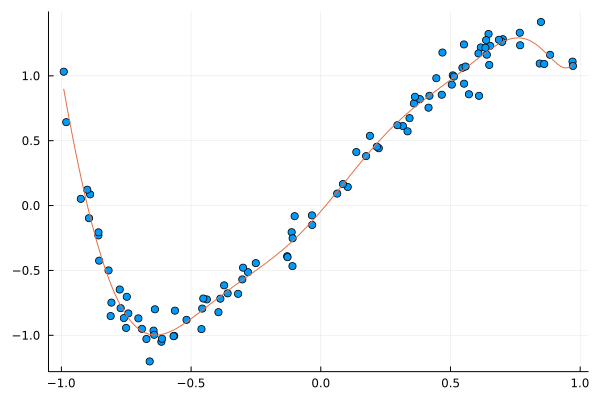

In [12]:
degrees = 10
X = (xv .|> x -> [x^n for n in degrees:-1:0])
X = hcat(X...)'
w = (X'X)^-1 * X'Y
scatter(xv, Y, legend = false)
print("SSE = ", (X*w -Y)'*(X*w -Y))
plot!(x -> dot([x^n for n in degrees:-1:0],w))

Still looks like the previous solution, but you could use more degrees.

SSE = 0.893798316635279

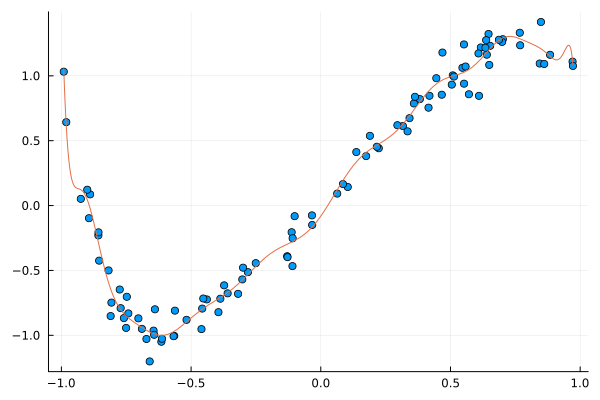

In [13]:
degrees = 20
X = (xv .|> x -> [x^n for n in degrees:-1:0])
X = hcat(X...)'
w = (X'X)^-1 * X'Y
scatter(xv, Y, legend = false)
print("SSE = ", (X*w -Y)'*(X*w -Y))
plot!(x -> dot([x^n for n in degrees:-1:0],w))

You're clearly overfitting at this point, but still, you know that a sufficiently high degree polynomial can fit any function, so why stop here?

SSE = 7790.77754304747

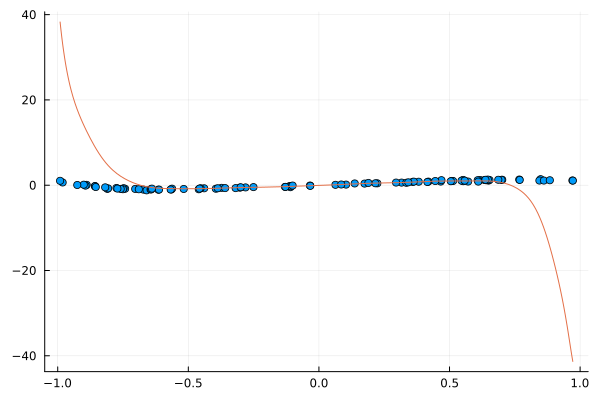

In [14]:
degrees = 30
X = (xv .|> x -> [x^n for n in degrees:-1:0])
X = hcat(X...)'
w = (X'X)^-1 * X'Y
scatter(xv, Y, legend = false)
print("SSE = ", (X*w -Y)'*(X*w -Y))
plot!(x -> dot([x^n for n in degrees:-1:0],w))

Woah our regression broke. But why?. We know that if the degree is equal to the number of data points we can perfectly interpolate the data, so let's try that.

SSE = 858224.5605850877

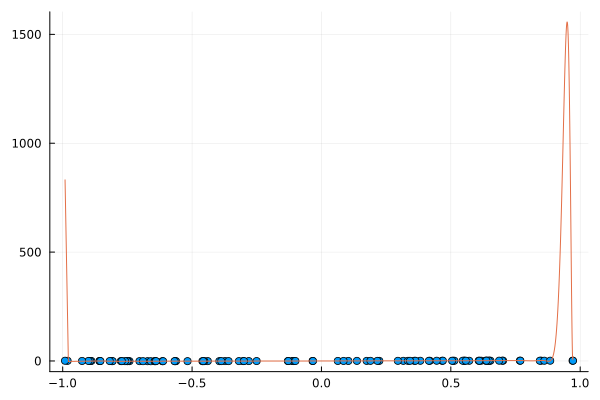

In [15]:
degrees = 100
X = (xv .|> x -> [x^n for n in degrees:-1:0])
X = hcat(X...)'
w = (X'X)^-1 * X'Y
scatter(xv, Y, legend = false)
print("SSE = ", (X*w -Y)'*(X*w -Y))
plot!(x -> dot([x^n for n in degrees:-1:0],w))

Somehow we got a worse result. We can construct a formulation for this polynomial that will give us this exact result.

$f(x) = x_0 + x_1(x - x_0) + x_2(x - x_1)(x - x_0) ...$

As we can see, wh